<a href="https://colab.research.google.com/github/chandana1012/COVID-19/blob/Master/covid19_detection_for_binary_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from fastai.vision import *

In [4]:
!git clone https://github.com/chandana1012/COVID-19.git


Cloning into 'COVID-19'...
remote: Enumerating objects: 638, done.
remote: Total 638 (delta 0), reused 0 (delta 0), pack-reused 638
Receiving objects: 100% (638/638), 209.85 MiB | 50.05 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [5]:
!ln -s "/content/COVID-19/X-RAY DATASET" /content/COVID-19/X-Ray_Image_DataSet

In [6]:
path = Path('/content/COVID-19/X-Ray_Image_DataSet/')
print(path)

/content/COVID-19/X-Ray_Image_DataSet


In [7]:
np.random.seed(41)
#data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid", ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()
data = ImageDataBunch.from_folder('/content/COVID-19/X-Ray_Image_DataSet/', train="/content/COVID-19/X-Ray_Image_DataSet/Train", valid ="/content/COVID-19/X-Ray_Image_DataSet/Valid", 
                                  ds_tfms=get_transforms(), valid_pct=0.2,size=(256,256), bs=32, num_workers=4).normalize()

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds) 

(['Covid-19', 'No_findings'], 2, 500, 125)

In [9]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 500
Number of examples in validation: 125


In [10]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

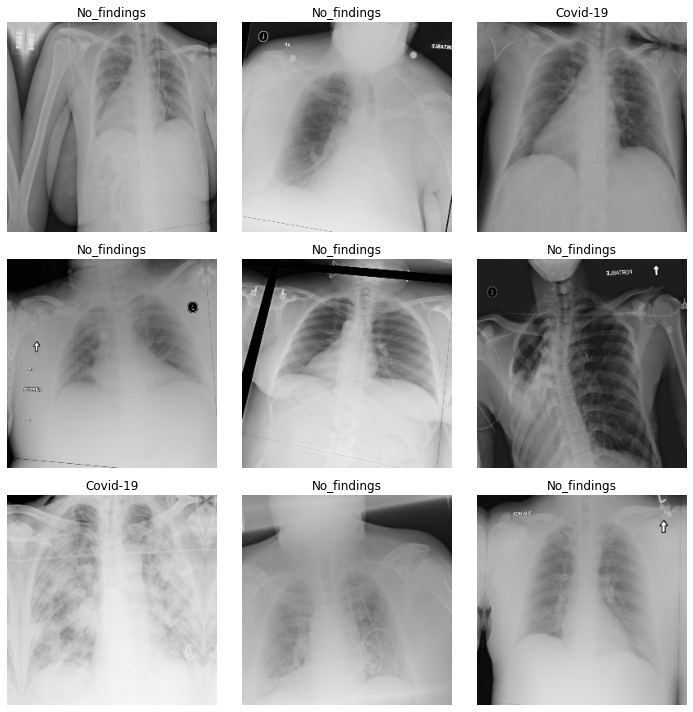

In [11]:
data.show_batch(rows=3, figsize=(10,10))

In [12]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [13]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [14]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [15]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [16]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [17]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [18]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.452749,0.998183,0.152000,00:23
1,0.333454,1.278086,0.152000,00:23
2,0.266653,0.254505,0.904000,00:23
3,0.222754,0.091878,0.944000,00:23
4,0.191538,0.103612,0.952000,00:23
5,0.159698,0.072545,0.984000,00:23
6,0.147004,0.089260,0.976000,00:23
7,0.144828,0.140242,0.928000,00:23
8,0.143476,0.106415,0.960000,00:23
9,0.141331,0.084197,0.968000,00:22


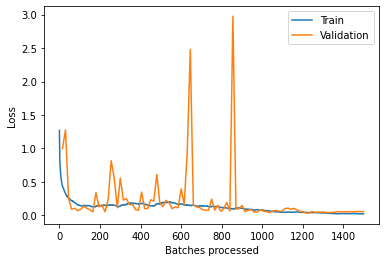

In [19]:
learn.recorder.plot_losses()

In [20]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 125


In [21]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [22]:
accuracy(probs,targets)

tensor(0.9840)

In [23]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings'], 2, 500, 125)

In [24]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)
from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings']
print(classification_report(y_true1, y_pred1, target_names=target_names))

125 123 0.984
[[ 18   1]
 [  1 105]]
              precision    recall  f1-score   support

    Covid-19       0.95      0.95      0.95        19
 No_findings       0.99      0.99      0.99       106

    accuracy                           0.98       125
   macro avg       0.97      0.97      0.97       125
weighted avg       0.98      0.98      0.98       125



In [25]:
interp = ClassificationInterpretation.from_learner(learn)

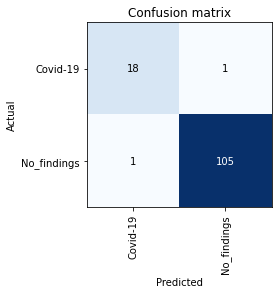

In [26]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);